In [108]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import time
import sys
sys.path.append('C:/Users/Simon/JUPYTERLAB/CNN - Udacity/Cours CNN')
#import fc_model
import helper

In [109]:
#  obtenir le répertoire de travail actuel 
import os
current_directory = os.getcwd()
print(current_directory)

C:\Users\Simon\JUPYTERLAB\CNN - Udacity


In [110]:
# Tester si GPU ou CPU utilisé pour les calculs
import torch
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Target device is {device}")

Target device is gpu


## Transforms and load data

In [111]:

data_dir = 'Cat_Dog_data'

# Define transforms for the training data and testing data
    # Most of the pretrained models require the input to be 224x224 images
    # Les valeurs de normalisation [0.485, 0.456, 0.406] pour les moyennes et [0.229, 0.224, 0.225] pour les écarts-types sont celles utilisées pour les images ImageNet lors de l'entraînement de nombreux modèles pré-entraînés disponibles dans PyTorch. Ces valeurs de normalisation sont devenues une sorte de standard dans la communauté de l'apprentissage profond pour les images RGB parce que les modèles pré-entraînés, tels que ResNet, ont été optimisés avec ces valeurs pendant leur entraînement sur ImageNet​
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256), 
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

## Information sur le dataset

In [113]:
def dataset_info(data_loader):
    num_batches = len(data_loader)
    batch_size = data_loader.batch_size
    total_images = num_batches * batch_size

    # Pour récupérer la taille des images, nous examinons le premier batch
    first_batch_images, _ = next(iter(data_loader))
    image_shape = first_batch_images[0].shape

    print(f"Nombre total d'images: {total_images}")
    print(f"Nombre de batches: {num_batches}")
    print(f"Taille d'un batch: {batch_size}")
    print(f"Taille des images: {image_shape}")  # C, H, W

# Utilisation pour les données d'entraînement et de test
print("Informations sur les données d'entraînement:")
dataset_info(trainloader)

print("\nInformations sur les données de test:")
dataset_info(testloader)

Informations sur les données d'entraînement:
Nombre total d'images: 22528
Nombre de batches: 352
Taille d'un batch: 64
Taille des images: torch.Size([3, 224, 224])

Informations sur les données de test:
Nombre total d'images: 2528
Nombre de batches: 79
Taille d'un batch: 32
Taille des images: torch.Size([3, 224, 224])


## Visualiser la premiere image

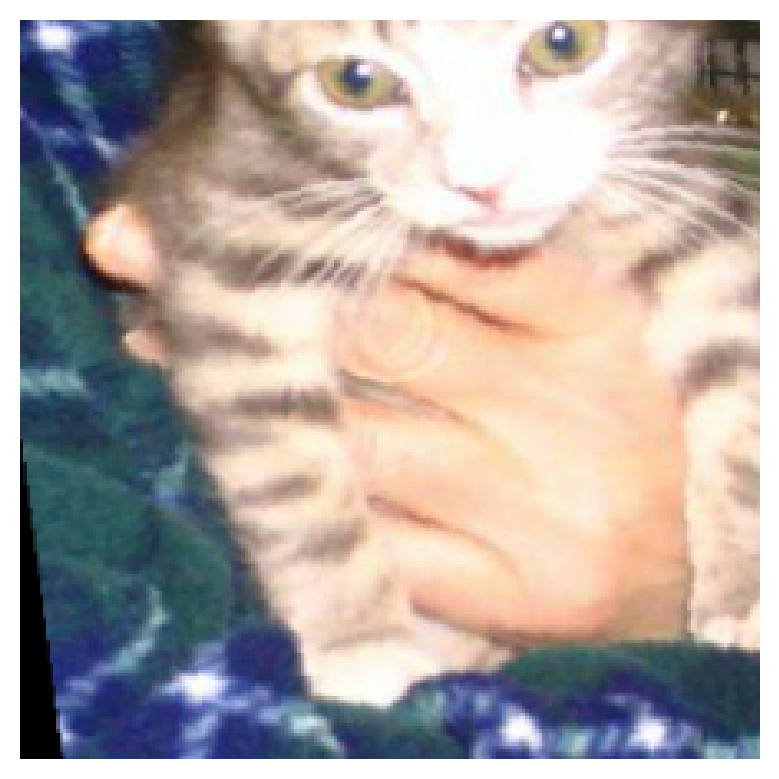

In [114]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

## Utiliser un réseau préentrainer

In [115]:
## Utiliser un réseau préentrainer (ImageNet) en faisant du Transfert Learning des poids
model = models.densenet121(weights=True)
    #charger le model et regarder son architecture
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [116]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# modifier le classificateur du model afin de pouvoir l'entrainer avec nos données
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [117]:
# Définir le loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [118]:
# Fonction qui prend en compte le type de device (gpu/cuda ou cpu)
def do_deep_learning(model, trainloader, epochs, print_every, criterion, optimizer, device):
    epochs = epochs
    print_every = print_every
    steps = 0

    # change to cuda
    model.to(device)

    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))

                running_loss = 0
    
# Mesurer le temps d'exécution
import time
start_time = time.time()

# Vérifier si CUDA est disponible, sinon utiliser CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Target device is {device}")
    
# Train a model with a pre-trained network
do_deep_learning(model, trainloader, 3, 40, criterion, optimizer, device=device)

# Afficher le temps d'exécution
end_time = time.time()
print(f"Temps d'exécution: {(end_time - start_time)} secondes")

Target device is cuda
Epoch: 1/1...  Loss: 0.2906
Epoch: 1/1...  Loss: 0.1979
Epoch: 1/1...  Loss: 0.1606
Epoch: 1/1...  Loss: 0.1571
Epoch: 1/1...  Loss: 0.1789
Epoch: 1/1...  Loss: 0.1470
Epoch: 1/1...  Loss: 0.1515
Epoch: 1/1...  Loss: 0.1574
Temps d'exécution: 1151.090541601181 secondes


In [119]:
# tester la précision du model (cours UDACY)
def check_accuracy_on_test(testloader,device):   
    model.to(device)
    model.eval() #
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

check_accuracy_on_test(testloader, device)

Accuracy of the network on the 10000 test images: 98 %


In [122]:
# tester la précision et perte totale (CHATGPT)
def validation(model, testloader, criterion, device):
        # Détection de Surajustement (Overfitting) : Un modèle peut avoir une faible perte totale sur les données d'entraînement mais une mauvaise précision sur les données de test, ce qui pourrait indiquer un surajustement. La surveillance de ces deux mesures aide à identifier et à corriger ce problème.
    # Équilibrage entre Précision et Robustesse : Dans certains cas, il peut y avoir un compromis entre la précision et la robustesse du modèle (sa capacité à gérer des données nouvelles ou bruitées). Mesurer à la fois la perte et la précision aide à trouver le bon équilibre
    # Amélioration Guidée du Modèle : En comprenant où et comment le modèle fait des erreurs (via la perte) et réussit (via la précision), on peut mieux guider les efforts d'amélioration du modèle
    model.eval()  # Mettre le modèle en mode évaluation
    test_loss = 0
    correct = 0
    total = 0
    model.to(device)

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            test_loss += criterion(outputs, labels).item() #  perte totale fournit une mesure quantitative de l'erreur du modèle

            # Calcul de l'accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total  # Accuracy en pourcentage      
    model.train()  # Remettre le modèle en mode d'entraînement

    return test_loss, accuracy

# Utiliser la fonction de validation 
test_loss, test_accuracy = validation(model, testloader, criterion, device) 
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}%")

Test Loss: 3.393, Test Accuracy: 98.160%


## Sauvegarder et charger l'apprentissage

In [123]:
def save_checkpoint(model, filepath):
    checkpoint = {
        'arch': 'densenet121',
        'classifier': model.classifier,  # Sauvegarder la structure du classificateur
        'state_dict': model.state_dict()  # Sauvegarder les poids et biais
    }
    torch.save(checkpoint, filepath)

# Utilisation
save_checkpoint(model, 'checkpoint.pth')


In [124]:
def load_checkpoint(filepath,pretrained=True):
    checkpoint = torch.load(filepath)
    model = models.densenet121(pretrained)
    
    # Assurez-vous que les paramètres du classificateur ne soient pas gelés
    for param in model.parameters():
        param.requires_grad = True
    
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

# Utilisation
model = load_checkpoint(filepath='checkpoint.pth',pretrained=True)

In [125]:
# tester si le model c'est bien chargé
test_loss, test_accuracy = validation(model, testloader, criterion, device) 
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}%")

Test Loss: 3.393, Test Accuracy: 98.160%


## Entrainer un nouveau model sans Transfert Learning

In [86]:
# définir le network
denseNetWithoutTL = models.densenet121(weights=None) # weights=None => pas de transfert learning

# Définir un classificateur personnalisé pour denseNetWithoutTL
denseNetWithoutTL.classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 500)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(500, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

# Définir le loss et l'optimizer pour denseNetWithoutTL
optimizer_withoutTL = optim.Adam(denseNetWithoutTL.classifier.parameters(), lr=0.001)


In [87]:
# Utiliser denseNetWithoutTL dans les fonctions d'entraînement et d'évaluation
do_deep_learning(denseNetWithoutTL, trainloader, 3, 40, criterion, optimizer_withoutTL, device=device)
check_accuracy_on_test(testloader, device)

Epoch: 1/1...  Loss: 0.7016
Epoch: 1/1...  Loss: 0.6736
Epoch: 1/1...  Loss: 0.6589
Epoch: 1/1...  Loss: 0.6459
Epoch: 1/1...  Loss: 0.6478
Epoch: 1/1...  Loss: 0.6429
Epoch: 1/1...  Loss: 0.6545
Epoch: 1/1...  Loss: 0.6529
Accuracy of the network on the 10000 test images: 0 %


In [88]:
# sauvegarder l'apprentissage
save_checkpoint(denseNetWithoutTL, 'checkpoint_denseNetWithoutTL.pth')

In [126]:
# Tester la précision et perte total
test_loss, test_accuracy = validation(denseNetWithoutTL, testloader, criterion, device) 
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}%")

Test Loss: 52.014, Test Accuracy: 60.280%


In [128]:
def load_checkpoint(filepath,pretrained=True):  
    checkpoint = torch.load(filepath)
    model = models.densenet121(pretrained)
    
    # Assurez-vous que les paramètres du classificateur ne soient pas gelés
    for param in model.parameters():
        param.requires_grad = True
    
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

# Utilisation
denseNetWithoutTL = load_checkpoint(filepath='checkpoint_denseNetWithoutTL.pth',pretrained=True)

In [129]:
# Tester la précision et perte total
test_loss, test_accuracy = validation(denseNetWithoutTL, testloader, criterion, device) 
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}%")

Test Loss: 49.632, Test Accuracy: 65.760%
